This notebook is designed for the validation of Spec2Vec's model for negative ionization mode at a bigger scale. In this notebook a small cleaned and deduplicated spectral library will be used with 230 negative ionized spectra. All of the 230 spectra will be used as a query for Spec2Vec!

In [8]:
from matchms.importing import load_from_mgf
cleaned_deduplicated = list(load_from_mgf("/home/ioannis/thesis_data/GNPS-NIST14-MATCHES_neg_cleaned_deduplicated.mgf")) 
print("Loaded spectra:", len(cleaned_deduplicated))

Loaded spectra: 230


In [9]:
import gensim
from matchms import calculate_scores
from spec2vec import Spec2Vec

In [10]:
spec2vec_model = ("/home/ioannis/MS2LDA/MS2LDA/Add_On/Spec2Vec/model_negative_mode/061125_s2v_filtered_neg.model") 
model = gensim.models.Word2Vec.load(spec2vec_model)

In [11]:
spec2vec_similarity = Spec2Vec(model=model, intensity_weighting_power=0.5, allowed_missing_percentage=5.0)

In [12]:
def prepare_query(query_spec):
    """
    Prepare the query spectrum for validation.
    Returns the query fingerprint (MACCS).
    """
    query_smiles = query_spec.get("smiles")
    if not query_smiles:
        raise ValueError("Query SMILES missing")
    query_mol = mol_from_smiles(query_smiles)
    fp_query = fp_maccs(query_mol)

    return fp_query

In [13]:
def exclude_query_from_library(query, library):
    """Return library without the exact query spectrum."""
    q_id = query.get("spectrum_id")
    library_excl = [spec for spec in library if spec.get("spectrum_id") != q_id]
    return library_excl

In [19]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys, DataStructs

def mol_from_smiles(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        Chem.SanitizeMol(mol)  # normalize valence/aromaticity
    return mol

def fp_maccs(mol):
    return MACCSkeys.GenMACCSKeys(mol)

def tanimoto(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [20]:
import pandas as pd

def summarize_top_bottom(query_spec, spec2vec_scores, fp_query, spec_to_meta, label="Query"):
    """
    Accepts Spec2Vec scores as (Spectrum, Spectrum, [score]) tuples.
    Looks up metadata directly from spec_to_meta keyed by Spectrum.
    """
    rows = []
    for reference, query, scores in spec2vec_scores:
        s2v_score = scores[0]

        if pd.isna(s2v_score):
            continue

        if reference not in spec_to_meta:
            continue

        spec = spec_to_meta[reference]
        smi = spec.get("smiles")
        mol = mol_from_smiles(smi) if smi else None
        if mol:
            fp_ref = fp_maccs(mol)
            t = tanimoto(fp_query, fp_ref)
            rows.append({
                "cand_inchikey": spec.get("inchikey"),
                "cand_adduct": spec.get("adduct"),
                "spec2vec": s2v_score,
                "maccs": t
            })

    if not rows:
        print(f"{label} | No valid candidates found.")
        return {
            "query_id": query_spec.get("spectrum_id"),
            "top5_maccs_median": float("nan"),
            "bottom5_maccs_median": float("nan"),
            "median_diff": float("nan"),
            "n_candidates": 0
        }

    df = pd.DataFrame(rows).sort_values("spec2vec", ascending=False)

    top5 = df.head(5)["maccs"].median() if len(df) >= 5 else float("nan")
    bottom5 = df.tail(5)["maccs"].median() if len(df) >= 5 else float("nan")
    diff = top5 - bottom5 if pd.notna(top5) and pd.notna(bottom5) else float("nan")

    print(f"{label} | Top-5 median MACCS={top5:.3f}, Bottom-5 median MACCS={bottom5:.3f}, Diff={diff:.3f}")

    return {
        "query_id": query_spec.get("spectrum_id"),
        "top5_maccs_median": top5,
        "bottom5_maccs_median": bottom5,
        "median_diff": diff,
        "n_candidates": len(df)
    }

In [ ]:
results = []

for i, query in enumerate(cleaned_deduplicated):
    print(f"\n--- Running Query {i+1} ---")

    # exclude query from library
    library_excl = exclude_query_from_library(query, cleaned_deduplicated)

    # build dictionary keyed by Spectrum
    spec_to_meta = {spec: spec for spec in library_excl}

    # compute Spec2Vec scores (returns Spectrum, Spectrum, [score])
    spec2vec_scores = calculate_scores(library_excl, [query], spec2vec_similarity)

    # prepare query fingerprint
    fp_query = prepare_query(query)

    # evaluate top-5 vs bottom-5
    result = summarize_top_bottom(query, spec2vec_scores, fp_query, spec_to_meta, label=f"Query {i+1}")
    results.append(result)

# aggregate results across queries
summary = pd.DataFrame(results)

print("\nAggregate stats:")
print(summary.describe())

fraction_enriched = (summary["median_diff"] > 0).mean()
print(f"\nFraction of queries enriched (top-5 > bottom-5): {fraction_enriched:.2f}")


--- Running Query 1 ---
2025-12-05 13:12:45,944:WARNING:spec2vec:vector_operations:('Missing percentage (8.02%) is above set maximum. An empty vector will be returned.', 'Consider retraining the used model or change the `allowed_missing_percentage`.')
2025-12-05 13:12:45,956:WARNING:spec2vec:vector_operations:('Missing percentage (33.80%) is above set maximum. An empty vector will be returned.', 'Consider retraining the used model or change the `allowed_missing_percentage`.')
2025-12-05 13:12:45,985:WARNING:spec2vec:vector_operations:('Missing percentage (14.61%) is above set maximum. An empty vector will be returned.', 'Consider retraining the used model or change the `allowed_missing_percentage`.')
2025-12-05 13:12:46,005:WARNING:spec2vec:vector_operations:('Missing percentage (7.45%) is above set maximum. An empty vector will be returned.', 'Consider retraining the used model or change the `allowed_missing_percentage`.')
2025-12-05 13:12:46,014:WARNING:spec2vec:vector_operations:('

/tmp/ipykernel_24453/2585476907.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Group", y="MACCS_median", data=plot_df, palette="Set2")


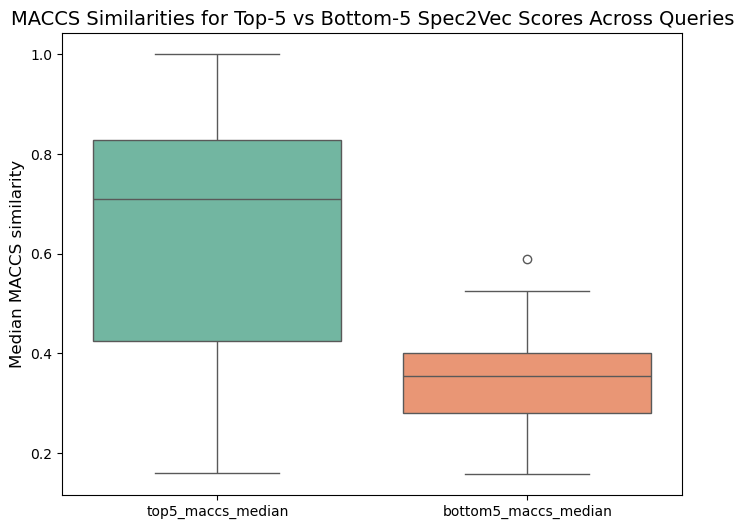

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape summary DataFrame for plotting
plot_df = summary.melt(
    value_vars=["top5_maccs_median", "bottom5_maccs_median"],
    var_name="Group", value_name="MACCS_median"
)

plt.figure(figsize=(8,6))
sns.boxplot(x="Group", y="MACCS_median", data=plot_df, palette="Set2")

plt.title("MACCS Similarities for Top-5 vs Bottom-5 Spec2Vec Scores Across Queries", fontsize=14)
plt.ylabel("Median MACCS similarity", fontsize=12)
plt.xlabel("")
plt.show()

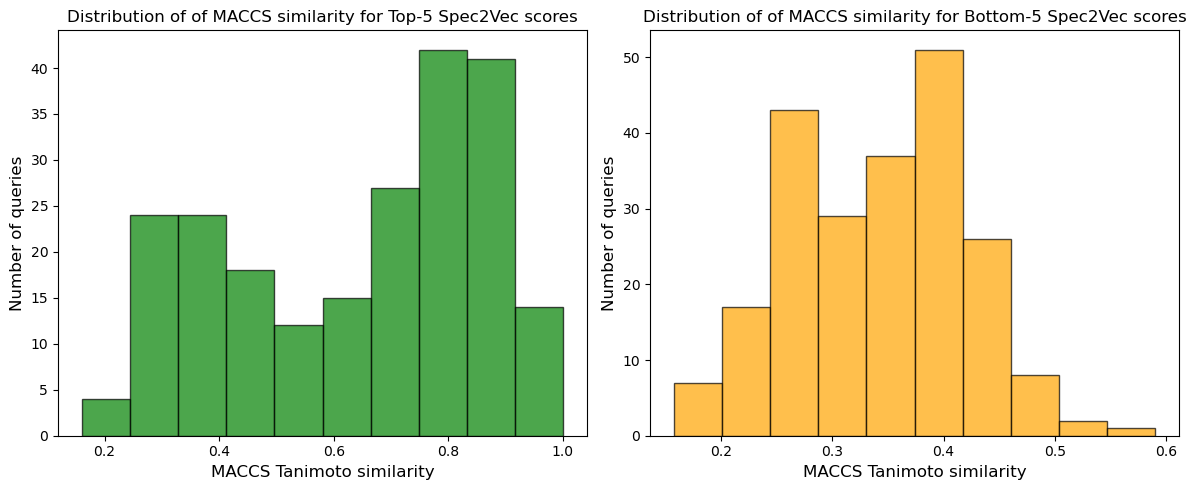

In [23]:
plt.figure(figsize=(12,5))

# Histogram for Top-5 median MACCS
plt.subplot(1,2,1)
plt.hist(summary["top5_maccs_median"].dropna(), bins=10, edgecolor="black", alpha=0.7, color="green")
plt.xlabel("MACCS Tanimoto similarity", fontsize=12)
plt.ylabel("Number of queries", fontsize=12)
plt.title("Distribution of of MACCS similarity for Top-5 Spec2Vec scores")

# Histogram for Bottom-5 median MACCS
plt.subplot(1,2,2)
plt.hist(summary["bottom5_maccs_median"].dropna(), bins=10, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("MACCS Tanimoto similarity", fontsize=12)
plt.ylabel("Number of queries", fontsize=12)
plt.title("Distribution of of MACCS similarity for Bottom-5 Spec2Vec scores")

plt.tight_layout()
plt.show()


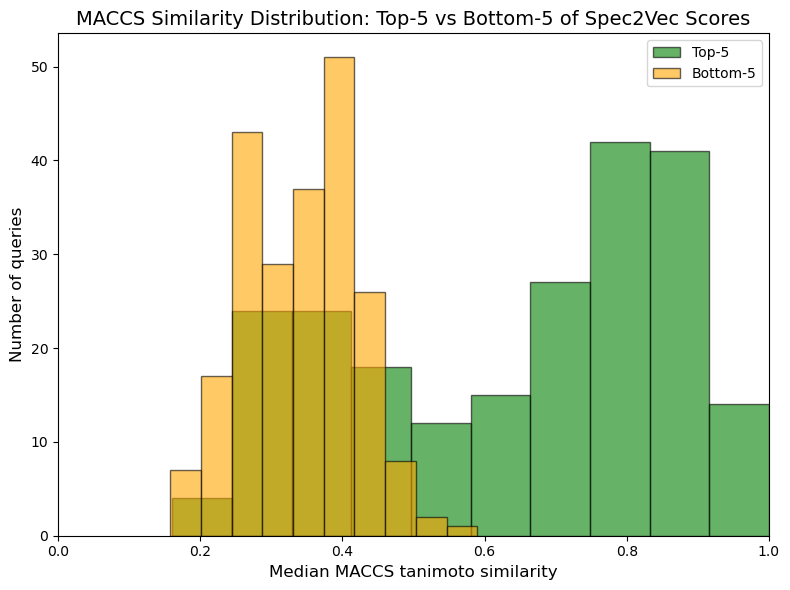

In [24]:
plt.figure(figsize=(8,6))

# Plot both histograms on the same axes
plt.hist(summary["top5_maccs_median"].dropna(), bins=10, alpha=0.6, label="Top-5", color="green", edgecolor="black")
plt.hist(summary["bottom5_maccs_median"].dropna(), bins=10, alpha=0.6, label="Bottom-5", color="orange", edgecolor="black")

# Formatting
plt.xlabel("Median MACCS tanimoto similarity", fontsize=12)
plt.ylabel("Number of queries", fontsize=12)
plt.title("MACCS Similarity Distribution: Top-5 vs Bottom-5 of Spec2Vec Scores", fontsize=14)
plt.legend()
plt.xlim(0, 1)  # Force scale from 0 to 1

plt.tight_layout()
plt.show()


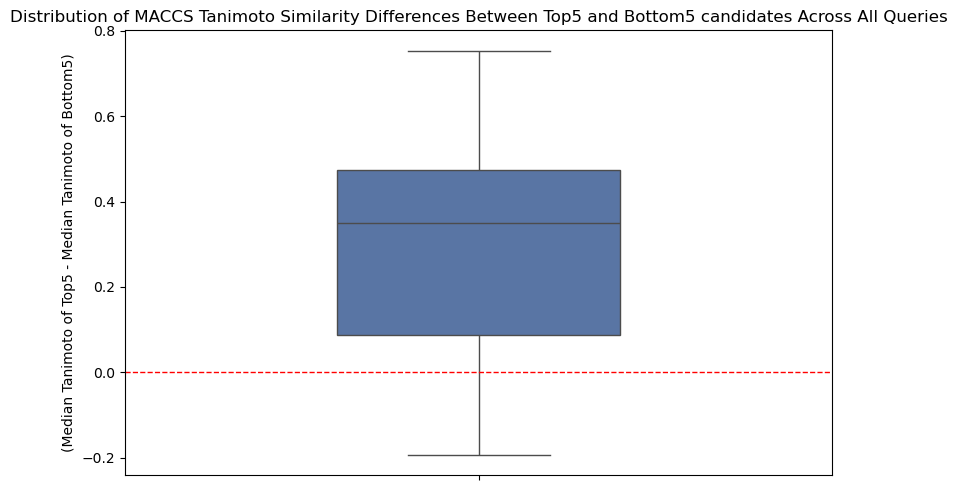

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(y=summary["median_diff"], color="#4C72B0", width=0.4)

plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.ylabel("(Median Tanimoto of Top5 - Median Tanimoto of Bottom5)")
plt.title("Distribution of MACCS Tanimoto Similarity Differences Between Top5 and Bottom5 candidates Across All Queries")

plt.tight_layout()
plt.show()